In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os

# Preparing the data 

## Ensuring a good format from Gemini

In [2]:
df = pd.read_csv('gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
df['Analysis Result'] = df['Analysis Result'].str.extract(r'\[(.*)\]')

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_8896\2971901269.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_8896\2971901269.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
Skipping line 22559: expected 2 fields, saw 9



In [3]:
df.head()

,Image Name,Analysis Result
0,roi_0_0.jpeg,"""Sky"", ""Road"", ""Soil"", ""Tree"", ""Vegetation"", ""..."
1,roi_10006_0.jpeg,"""House"", ""Building"", ""Car"", ""Vehicle"", ""Road"",..."
2,roi_10009_0.jpeg,"""Vegetation"", ""Wall"", ""Soil"", ""Bush"""
3,roi_10009_1.jpeg,"""Sky"""
4,roi_10009_2.jpeg,"""Sky"""


In [4]:
# Convert all values in the column to strings, then split
df['Analysis Result'] = df['Analysis Result'].apply(
    lambda x: [item.replace('"', '').replace("'", "") for item in str(x).split(',')] if isinstance(x, str) else []
)

# Display the updated DataFrame
print(df.head())


         Image Name                                    Analysis Result
0      roi_0_0.jpeg  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...
1  roi_10006_0.jpeg  [House,  Building,  Car,  Vehicle,  Road,  Tre...
2  roi_10009_0.jpeg                  [Vegetation,  Wall,  Soil,  Bush]
3  roi_10009_1.jpeg                                              [Sky]
4  roi_10009_2.jpeg                                              [Sky]


Connecting the image with the original

In [5]:
# Extract the first number after "roi_" in the "Image Name" column
df['image_name'] = df['Image Name'].str.extract(r'roi_(\d+)_')

# Remove rows where 'First Number' is NaN
df = df.dropna(subset=['image_name'])

# Optionally, convert the column to integer after removing NaN rows
df['image_name'] = df['image_name'].astype(str)

# Add .png to the 'image_name' column
df['image_name'] = df['image_name'].apply(lambda x: f"{x}.png")

# Display the updated DataFrame
print(df.head())


         Image Name                                    Analysis Result  \
0      roi_0_0.jpeg  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...   
1  roi_10006_0.jpeg  [House,  Building,  Car,  Vehicle,  Road,  Tre...   
2  roi_10009_0.jpeg                  [Vegetation,  Wall,  Soil,  Bush]   
3  roi_10009_1.jpeg                                              [Sky]   
4  roi_10009_2.jpeg                                              [Sky]   

  image_name  
0      0.png  
1  10006.png  
2  10009.png  
3  10009.png  
4  10009.png  


In [6]:
# Group by 'First Number' and combine lists in 'Analysis Result'
df_combined = df.groupby('image_name', as_index=False).agg({
    'Analysis Result': 'sum'  # Combine lists by summing them
})

# Display the resulting DataFrame
print(df_combined.head())


  image_name                                    Analysis Result
0      0.png  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...
1      1.png  [Sky,  Tree,  Vegetation,  Bush, Sky,  Tree,  ...
2  10006.png  [House,  Building,  Car,  Vehicle,  Road,  Tre...
3  10009.png  [Vegetation,  Wall,  Soil,  Bush, Sky, Sky, Sk...
4  10011.png  [Sky,  Tree,  Vegetation,  Building,  House,  ...


# Plots for the main results

In [7]:
# Base directory containing the model folders
base_dir = 'models/'

# Initialize an empty list to store DataFrames
all_metrics = []

# Loop through each folder in the base directory
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Path to metrics.csv
        metrics_file = os.path.join(folder_path, 'metrics.csv')
        
        # Check if metrics.csv exists in the folder
        if os.path.exists(metrics_file):
            # Read the metrics.csv
            metrics_df = pd.read_csv(metrics_file)
            
            # Add a column for the model name
            metrics_df['model'] = folder
            
            # Append to the list of DataFrames
            all_metrics.append(metrics_df)

# Concatenate all DataFrames into a single DataFrame
final_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Display the resulting DataFrame
final_metrics_df

# Optionally save the final DataFrame to a CSV
output_file = os.path.join(base_dir, 'compiled_metrics.csv')
final_metrics_df.to_csv(output_file, index=False)

print(f'The file can be found here: {output_file}')


The file can be found here: models/compiled_metrics.csv


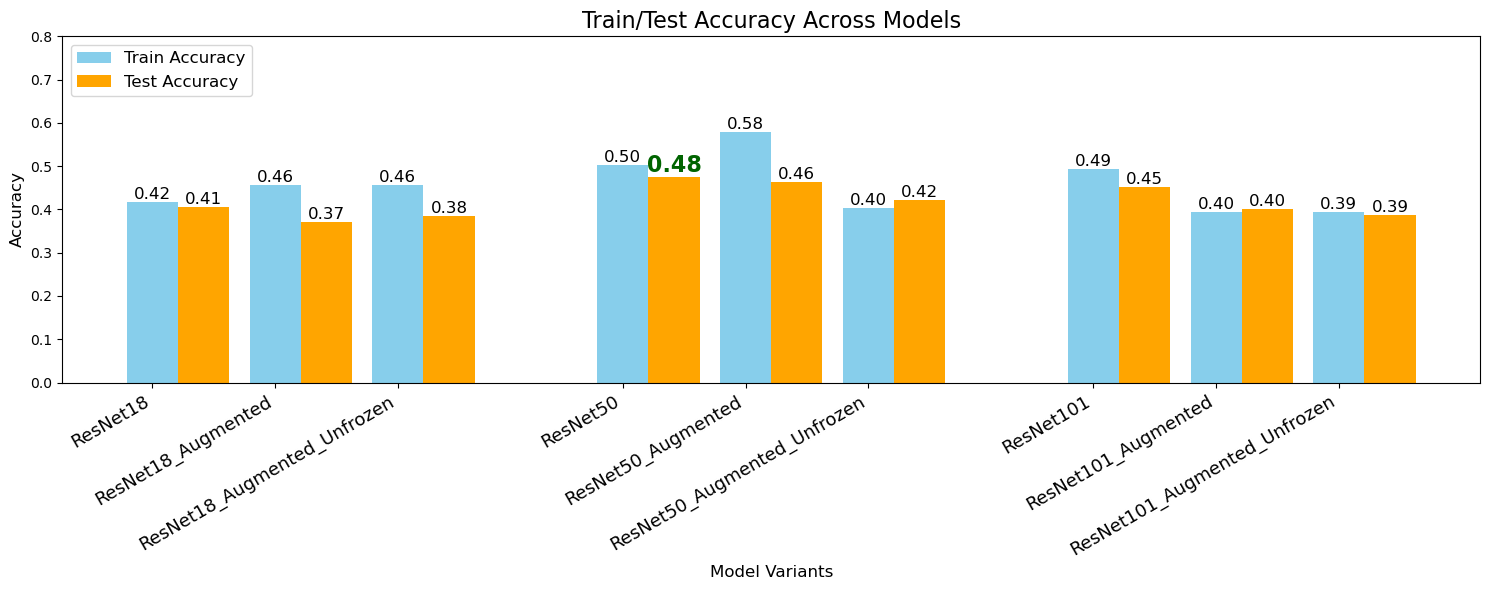

In [30]:
# Define the desired order of models
desired_order = [
    "ResNet18", 
    "ResNet18_Augmented", 
    "ResNet18_Augmented_Unfrozen", 
    "ResNet50", 
    "ResNet50_Augmented", 
    "ResNet50_Augmented_Unfrozen", 
    "ResNet101", 
    "ResNet101_Augmented",
    "ResNet101_Augmented_Unfrozen"
]

# Set the categorical order and sort the DataFrame
final_metrics_df['model'] = pd.Categorical(final_metrics_df['model'], categories=desired_order, ordered=True)
final_metrics_df = final_metrics_df.sort_values('model')

# Find the name of the model with the highest test accuracy
highest_model_name = final_metrics_df.loc[final_metrics_df['test_accuracy'].idxmax(), 'model']

# Find the position of this model in the desired_order list
highest_model_position = desired_order.index(highest_model_name)

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Define bar positions and width
model_sizes = ['ResNet18', 'ResNet50', 'ResNet101']
x_groups = [
    ["ResNet18", "ResNet18_Augmented", "ResNet18_Augmented_Unfrozen"],
    ["ResNet50", "ResNet50_Augmented", "ResNet50_Augmented_Unfrozen"],
    ["ResNet101", "ResNet101_Augmented", "ResNet101_Augmented_Unfrozen"]
]

width = 0.25

# Calculate positions for grouped bars
x_positions = []


group_spacing = 0.5 


current_position = 0
for group in x_groups:
    for model in group:
        x_positions.append(current_position)
        current_position += 0.6
    current_position += group_spacing  # Add spacing between groups

# Plot bar chart for accuracy, highlight highest test accuracy
bar1 = ax1.bar(
    x_positions, 
    final_metrics_df['train_accuracy'], 
    width, 
    label='Train Accuracy', 
    color='skyblue',
    align='center'
)
bar2_colors = ['orange' for _ in final_metrics_df.index]
bar2 = ax1.bar(
    [pos + width for pos in x_positions], 
    final_metrics_df['test_accuracy'], 
    width, 
    label='Test Accuracy', 
    color=bar2_colors,
    align='center'
)

# Add value labels to bars
for bar in bar1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{height:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=12
    )
for idx, bar in enumerate(bar2):
    height = bar.get_height()
    label_color = 'darkgreen' if idx == highest_model_position else 'black'
    fontweight = 'bold' if idx == highest_model_position else 'normal'
    fontsize = 16 if idx == highest_model_position else 12
    ax1.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{height:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=fontsize, 
        color=label_color, 
        fontweight=fontweight
    )

# Customize the primary y-axis (accuracy)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 0.8)  # Assuming accuracy is between 0 and 1
ax1.set_xticks(x_positions)
ax1.set_xticklabels(desired_order, rotation=30, ha='right', fontsize=13)
ax1.set_xlabel('Model Variants', fontsize=12)

# Add a title
plt.title('Train/Test Accuracy Across Models', fontsize = 16)

# Combine legends
ax1.legend(loc='upper left', fontsize = 12)

# Adjust layout
plt.tight_layout()
plt.show()


models\ResNet18\training_times.csv
models\ResNet18_Augmented\training_times.csv
models\ResNet18_Augmented_Unfrozen\training_times.csv
models\ResNet50\training_times.csv
models\ResNet50_Augmented\training_times.csv
models\ResNet50_Augmented_Unfrozen\training_times.csv
models\ResNet101\training_times.csv
models\ResNet101_Augmented\training_times.csv
models\ResNet101_Augmented_Unfrozen\training_times.csv


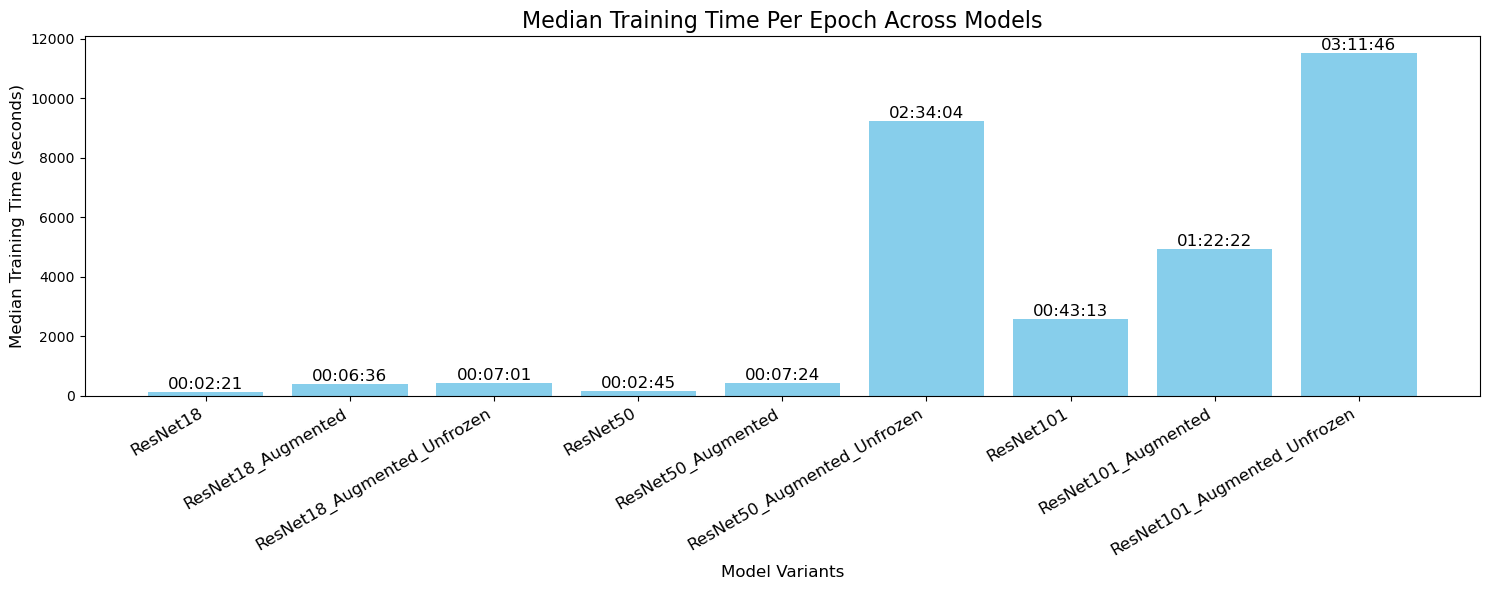

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the models and their respective directories
model_directories = [
    "ResNet18", 
    "ResNet18_Augmented", 
    "ResNet18_Augmented_Unfrozen", 
    "ResNet50", 
    "ResNet50_Augmented", 
    "ResNet50_Augmented_Unfrozen", 
    "ResNet101", 
    "ResNet101_Augmented",
    "ResNet101_Augmented_Unfrozen"
]

# Initialize a dictionary to store median times for each model
model_median_times = {}

# Base directory containing the model folders
base_directory = "models"  # Replace with the actual path

# Iterate through each model directory and extract median training time
for model in model_directories:
    file_path = os.path.join(base_directory, model, "training_times.csv")
    print(file_path)
    if os.path.exists(file_path):
        model_df = pd.read_csv(file_path)
        median_time = model_df['training_time'].median()  # Calculate median time in seconds
        model_median_times[model] = median_time

# Convert median times to hours, minutes, and seconds for labels
model_labels = []
median_times_in_seconds = []
formatted_time_labels = []


for model, time_seconds in model_median_times.items():
    median_times_in_seconds.append(time_seconds)
    model_labels.append(model)
    hours = int(time_seconds // 3600)
    minutes = int((time_seconds % 3600) // 60)
    seconds = int(time_seconds % 60)
    formatted_time_labels.append(f"{hours:02}:{minutes:02}:{seconds:02}")

# Create a bar chart to visualize training times
plt.figure(figsize=(15, 6))
bars = plt.bar(model_labels, median_times_in_seconds, color='skyblue')

# Add time labels above bars
for bar, label in zip(bars, formatted_time_labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, label, ha='center', va='bottom', fontsize=12)

# Customize the chart
plt.xlabel('Model Variants', fontsize=12)
plt.ylabel('Median Training Time (seconds)', fontsize=12)
plt.title('Median Training Time Per Epoch Across Models', fontsize=16)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.tight_layout()

# Display the chart
plt.show()


In [42]:
import os
import pandas as pd

# Define the models and their respective directories
model_directories = [
    "ResNet18", 
    "ResNet18_Augmented", 
    "ResNet18_Augmented_Unfrozen", 
    "ResNet50", 
    "ResNet50_Augmented", 
    "ResNet50_Augmented_Unfrozen", 
    "ResNet101", 
    "ResNet101_Augmented",
    "ResNet101_Augmented_Unfrozen"
]

# Base directory containing the model folders
base_directory = "models"  # Replace with the actual path

# Load final metrics DataFrame containing train and test accuracies
# Replace with the actual path or source of your metrics DataFrame
# Example: final_metrics_df = pd.read_csv("final_metrics.csv")
final_metrics_df['model'] = pd.Categorical(final_metrics_df['model'], categories=model_directories, ordered=True)
final_metrics_df = final_metrics_df.sort_values('model')

# Initialize a dictionary to store mean epoch training time
model_stats = []

# Iterate through each model directory to compute mean training time
for model in model_directories:
    file_path = os.path.join(base_directory, model, "training_times.csv")
    if os.path.exists(file_path):
        # Read the training times and calculate the mean time
        model_df = pd.read_csv(file_path)
        mean_time = model_df['training_time'].mean()  # Mean training time in seconds
        
        # Convert mean time to HH:MM:SS format
        hours = int(mean_time // 3600)
        minutes = int((mean_time % 3600) // 60)
        seconds = int(mean_time % 60)
        formatted_time = f"{hours:02}:{minutes:02}:{seconds:02}"
        
        # Get train and test accuracy for the model
        train_accuracy = round(final_metrics_df.loc[final_metrics_df['model'] == model, 'train_accuracy'].values[0],4)
        test_accuracy = round(final_metrics_df.loc[final_metrics_df['model'] == model, 'test_accuracy'].values[0],4)
        
        # Append the data to the list
        model_stats.append({
            "Model": model,
            "Mean Epoch Training Time (HH:MM:SS)": formatted_time,
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy
        })

# Create a DataFrame for the summary table
summary_table = pd.DataFrame(model_stats)

summary_table


,Model,Mean Epoch Training Time (HH:MM:SS),Train Accuracy,Test Accuracy
0,ResNet18,00:02:24,0.4182,0.4062
1,ResNet18_Augmented,00:06:43,0.4559,0.3714
2,ResNet18_Augmented_Unfrozen,00:07:03,0.4554,0.3840
3,ResNet50,00:02:47,0.5025,0.4756
4,ResNet50_Augmented,00:07:30,0.5788,0.4625
5,ResNet50_Augmented_Unfrozen,02:34:04,0.4034,0.4214
6,ResNet101,00:45:50,0.4940,0.4516
7,ResNet101_Augmented,01:22:22,0.3951,0.4017
8,ResNet101_Augmented_Unfrozen,03:11:46,0.3942,0.3866


As ResNet50 had the best test scores, it will be used for further analysis

In [9]:
df_preds = pd.read_csv("models/ResNet50/test_predictions.csv")

df_preds.head(3)

,Unnamed: 0,latitude,longitude,image_name,country_code,country,continent,region,alpha-2,sub-region,...,prob_Northern America,prob_Latin America and the Caribbean,prob_Sub-Saharan Africa,prob_Southern Europe,prob_Australia and New Zealand,prob_Southern Asia,prob_Western Europe,prob_Western Asia,prob_Eastern Asia,prob_nan
0,2968,5.249920,100.431950,14015.png,MY,Malaysia,Asia,Malaysia,MY,South-eastern Asia,...,0.100131,0.206869,0.055118,0.118279,0.033900,0.022319,0.033995,0.151216,0.061178,0.003014
1,4379,9.861000,124.055030,25144.png,PH,Philippines,Asia,Philippines,PH,South-eastern Asia,...,0.056460,0.209448,0.051842,0.079980,0.008075,0.047240,0.152399,0.007504,0.017292,0.001122
2,4457,-17.295768,141.577586,5520.png,AU,Australia,Oceania,Australia,AU,Australia and New Zealand,...,0.000336,0.033870,0.031975,0.001178,0.921858,0.005075,0.000181,0.001160,0.000689,0.000181


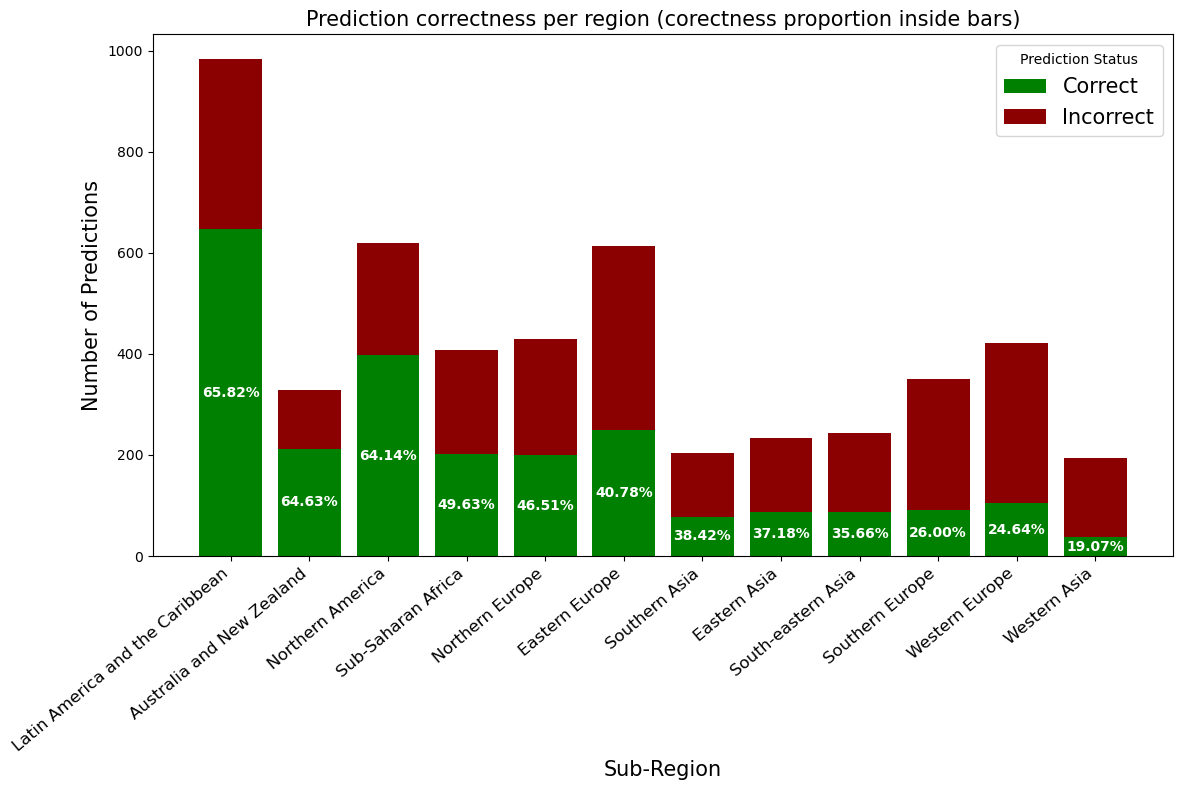

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df_preds' is your DataFrame; replace with the appropriate variable name
# Load your data if needed
# df_preds = pd.read_csv('path_to_your_file.csv')

# Create a new column "prediction_correct" by comparing 'sub-region' and 'model_prediction'
df_preds['prediction_correct'] = df_preds['sub-region'] == df_preds['model_prediction']

# Group df_preds by sub-region and count correct/incorrect predictions
summary = df_preds.groupby('sub-region')['prediction_correct'].value_counts().unstack(fill_value=0)

# Rename columns for clarity
summary.columns = ['Incorrect', 'Correct']

# Calculate the proportion of correct predictions for each sub-region
summary['Proportion Correct'] = summary['Correct'] / (summary['Correct'] + summary['Incorrect'])

# Reorder data by proportion correct
summary = summary.sort_values(by='Proportion Correct', ascending=False)

# Ensure proper handling of categorical axis
categories = summary.index.tolist()  # Get sub-region names as categories
x_positions = range(len(categories))  # Numerical positions for the bars

# Plot the stacked bar chart with custom colors
fig, ax = plt.subplots(figsize=(12, 8))
bars_correct = ax.bar(x_positions, summary['Correct'], color='green', label='Correct')
bars_incorrect = ax.bar(
    x_positions,
    summary['Incorrect'],
    bottom=summary['Correct'],
    color='darkred',
    label='Incorrect',
)

# Add proportions as labels inside the bars (white text above the green part)
for x, row in zip(x_positions, summary.itertuples()):
    proportion = row._3  # Access 'Proportion Correct' by position
    ax.text(
        x, 
        row.Correct / 2,  # Position in the middle of the green bar
        f"{proportion:.2%}", 
        ha='center', 
        va='center', 
        color='white', 
        fontsize=10, 
        fontweight='bold'
    )

# Customize the plot
ax.set_title('Prediction correctness per region (corectness proportion inside bars)', fontsize=15)
ax.set_xlabel('Sub-Region', fontsize=15)
ax.set_ylabel('Number of Predictions', fontsize=15)
ax.set_xticks(x_positions)
ax.set_xticklabels(categories, rotation=40, ha='right', fontsize=12)
ax.legend(title='Prediction Status', fontsize=15)

plt.tight_layout()
plt.show()


# Gemini results

Loading the data

In [11]:
# Flatten all lists in the "Analysis Result" column into a single list
# and standardize to lowercase
all_values = [
    item.strip().lower() for sublist in df_combined['Analysis Result'] if isinstance(sublist, list) for item in sublist
]

# Count the occurrences of each value
value_counts = Counter(all_values)

# Convert the counts to a DataFrame for better visualization
counts_df = pd.DataFrame(value_counts.items(), columns=['Object', 'Count']).sort_values(by='Count', ascending=False)

# Display the counts
print(counts_df)

         Object  Count
4    vegetation  15543
0           sky   7817
2          soil   7172
17      nothing   6831
7          bush   6732
..          ...    ...
98                   2
97     ski lift      2
96        slide      2
93       pigeon      2
154    contrail      2

[155 rows x 2 columns]


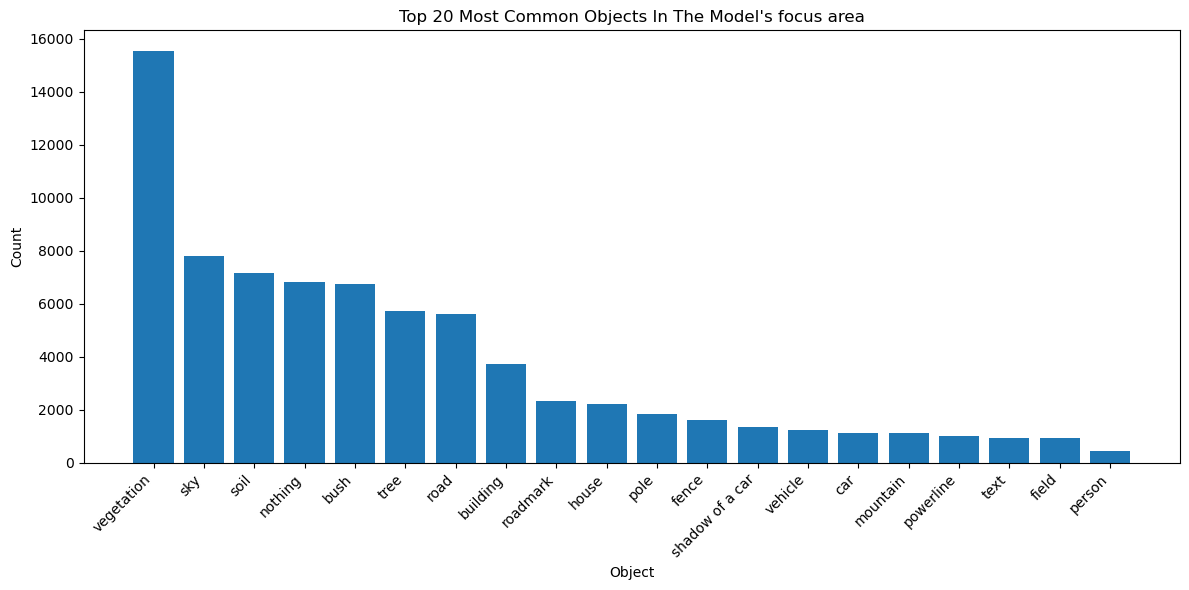

In [12]:
# Plot the top 20 most common values
top_n = 20
top_counts = counts_df.head(top_n)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_counts['Object'], top_counts['Count'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Object')
plt.ylabel('Count')
plt.title("Top 20 Most Common Objects In The Model's focus area")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [13]:
test_predictions_path = 'models/ResNet50/test_predictions.csv'
df_test_predictions = pd.read_csv(test_predictions_path)

# Merge the two datasets on the 'image_name' column
merged_df = pd.merge(df_combined, df_test_predictions[['image_name', 'sub-region', 'model_prediction']], on='image_name', how='left')

merged_df = merged_df.dropna()
# Display the merged DataFrame
merged_df.head()


,image_name,Analysis Result,sub-region,model_prediction
2,10006.png,"[House, Building, Car, Vehicle, Road, Tre...",Southern Europe,Northern America
3,10009.png,"[Vegetation, Wall, Soil, Bush, Sky, Sky, Sk...",Southern Europe,Southern Europe
4,10011.png,"[Sky, Tree, Vegetation, Building, House, ...",Southern Europe,Northern America
5,10012.png,"[Soil, Vegetation, Bush, Nothing, Vegetation...",Southern Europe,Northern America
6,10013.png,"[Nothing, Vegetation, House, Building, Moun...",Southern Europe,Latin America and the Caribbean


In [14]:
merged_df['sub-region'].value_counts()

Latin America and the Caribbean    983
Northern America                   619
Eastern Europe                     612
Northern Europe                    430
Western Europe                     422
Sub-Saharan Africa                 407
Southern Europe                    350
Australia and New Zealand          328
South-eastern Asia                 244
Eastern Asia                       233
Southern Asia                      203
Western Asia                       194
Name: sub-region, dtype: int64

In [15]:
# Create a new column 'is_correct' to indicate if the prediction matches the sub-region
merged_df['is_correct'] = merged_df['model_prediction'] == merged_df['sub-region']

# Display the updated DataFrame
merged_df.head()


,image_name,Analysis Result,sub-region,model_prediction,is_correct
2,10006.png,"[House, Building, Car, Vehicle, Road, Tre...",Southern Europe,Northern America,False
3,10009.png,"[Vegetation, Wall, Soil, Bush, Sky, Sky, Sk...",Southern Europe,Southern Europe,True
4,10011.png,"[Sky, Tree, Vegetation, Building, House, ...",Southern Europe,Northern America,False
5,10012.png,"[Soil, Vegetation, Bush, Nothing, Vegetation...",Southern Europe,Northern America,False
6,10013.png,"[Nothing, Vegetation, House, Building, Moun...",Southern Europe,Latin America and the Caribbean,False


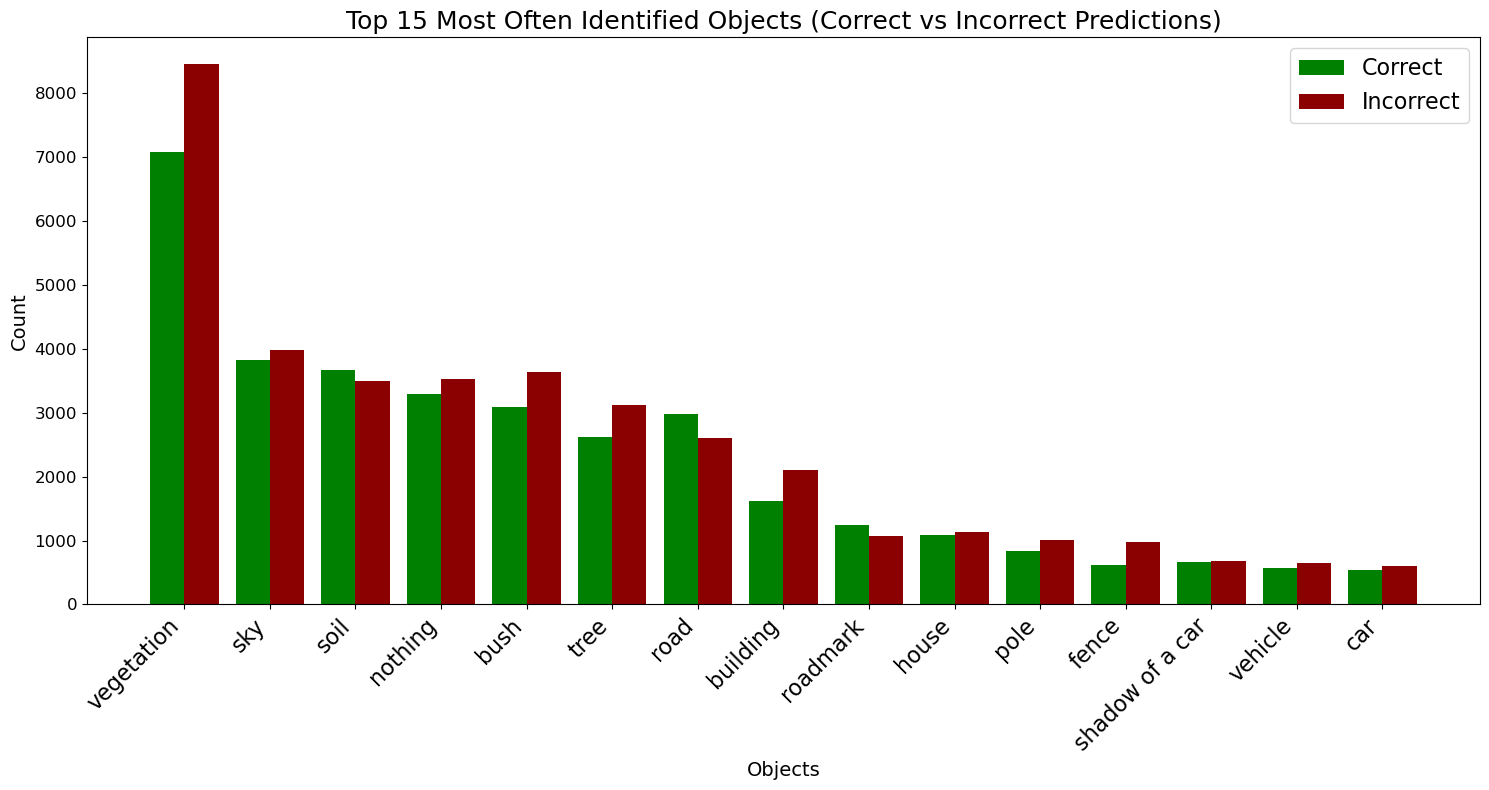

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Flatten all lists in the "Analysis Result" column into a single list, standardizing to lowercase
all_values_correct = [
    item.strip().lower()
    for sublist in merged_df[merged_df['is_correct']]['Analysis Result']
    if isinstance(sublist, list)
    for item in sublist
]
all_values_incorrect = [
    item.strip().lower()
    for sublist in merged_df[~merged_df['is_correct']]['Analysis Result']
    if isinstance(sublist, list)
    for item in sublist
]

# Count the occurrences of each value
correct_counts = Counter(all_values_correct)
incorrect_counts = Counter(all_values_incorrect)

# Combine counts into a DataFrame for visualization
objects = list(set(correct_counts.keys()).union(set(incorrect_counts.keys())))
df_preds = {
    'Object': objects,
    'Correct': [correct_counts.get(obj, 0) for obj in objects],
    'Incorrect': [incorrect_counts.get(obj, 0) for obj in objects],
}
plot_df = pd.DataFrame(df_preds)

# Sort by total count and keep the top 15 objects
plot_df['Total'] = plot_df['Correct'] + plot_df['Incorrect']
plot_df = plot_df.sort_values(by='Total', ascending=False).head(15)

# Plot a side-by-side bar chart
plt.figure(figsize=(15, 8))
bar_width = 0.4
x = range(len(plot_df))

# Plot bars for correct and incorrect counts side by side
plt.bar([p - bar_width / 2 for p in x], plot_df['Correct'], width=bar_width, label='Correct', color='green')
plt.bar([p + bar_width / 2 for p in x], plot_df['Incorrect'], width=bar_width, label='Incorrect', color='darkred')

# Add labels and legend with larger font sizes
plt.xlabel('Objects', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Top 15 Most Often Identified Objects (Correct vs Incorrect Predictions)', fontsize=18)
plt.xticks(x, plot_df['Object'], rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [17]:
# Explode the "Analysis Result" column to create one row per object
df_exploded = merged_df.explode('Analysis Result')

# Convert objects to lowercase for consistency
df_exploded['Analysis Result'] = df_exploded['Analysis Result'].str.strip().str.lower()

# Group by each unique object in the "Analysis Result" column and calculate statistics
object_stats = df_exploded.groupby('Analysis Result')['is_correct'].agg(
    total_occurrences='count',
    correct_predictions='sum',
    incorrect_predictions=lambda x: x.count() - x.sum()
).reset_index()

# Calculate the accuracy percentage for each object
object_stats['accuracy'] = (object_stats['correct_predictions'] / object_stats['total_occurrences']) * 100

# Sort by accuracy or total occurrences for analysis
object_stats = object_stats.sort_values(by='accuracy', ascending=False)

# Display the statistics
object_stats

,Analysis Result,total_occurrences,correct_predictions,incorrect_predictions,accuracy
0,,2,2,0,100.0
78,manhole,2,2,0,100.0
39,contrail,2,2,0,100.0
45,drain,2,2,0,100.0
49,fire hydrant,2,2,0,100.0
...,...,...,...,...,...
72,ladder,2,0,2,0.0
71,ice,2,0,2,0.0
70,hydrant,2,0,2,0.0
67,helicopter,2,0,2,0.0


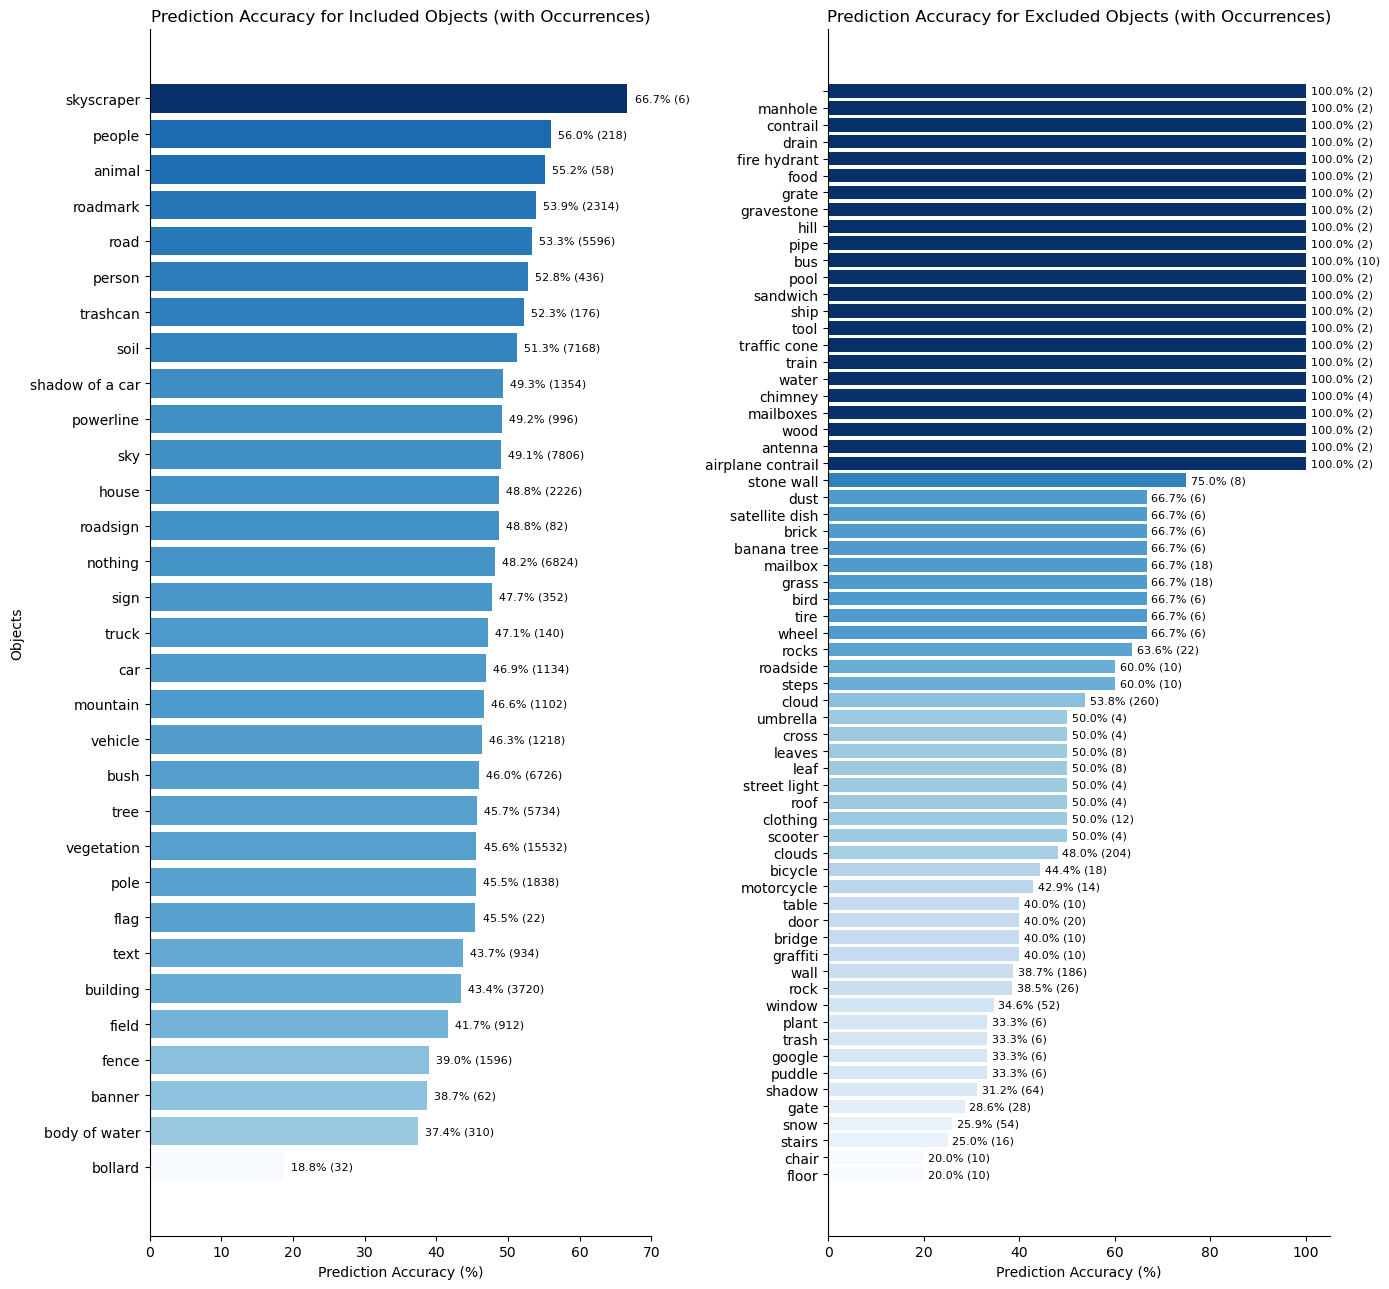

In [18]:
# Define the objects to include (those in the specified list)
objects_to_include = [
    "sky", "road", "roadmark", "soil", "building", "house", "pole", "tree",
    "trashcan", "shadow of a car", "car", "vehicle", "truck", "powerline", "sign", "banner",
    "roadsign", "fence", "bollard", "person", "text", "skyscraper", "mountain", "body of water",
    "nothing", "bush", "vegetation", 'people', "field", "flag", "animal"
]

# Remove quotes from the 'Analysis Result' column in the final_metrics_df
object_stats['Analysis Result'] = object_stats['Analysis Result'].str.replace('"', '')

# Filter object_stats to only include the specified objects in lowercase (for the included graph)
top_objects_filtered_included = object_stats[object_stats['Analysis Result'].str.lower().isin(objects_to_include)]

# Filter object_stats to exclude the specified objects in lowercase (for the excluded graph)
top_objects_filtered_excluded = object_stats[~object_stats['Analysis Result'].str.lower().isin(objects_to_include)]

# Remove objects with 0 accuracy from both DataFrames
top_objects_filtered_included = top_objects_filtered_included[top_objects_filtered_included['accuracy'] > 0]
top_objects_filtered_excluded = top_objects_filtered_excluded[top_objects_filtered_excluded['accuracy'] > 0]

# Create a color map based on accuracy values (higher accuracy = darker blue)
norm_included = plt.Normalize(vmin=top_objects_filtered_included['accuracy'].min(), vmax=top_objects_filtered_included['accuracy'].max())
norm_excluded = plt.Normalize(vmin=top_objects_filtered_excluded['accuracy'].min(), vmax=top_objects_filtered_excluded['accuracy'].max())

cmap = plt.cm.Blues  # Color map (you can choose others like 'viridis', 'plasma', etc.)
colors_included = [cmap(norm_included(acc)) for acc in top_objects_filtered_included['accuracy']]
colors_excluded = [cmap(norm_excluded(acc)) for acc in top_objects_filtered_excluded['accuracy']]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 13))  # Create a 1x2 grid of subplots

# Plot the first chart (left side) for included objects
bars1 = axes[0].barh(top_objects_filtered_included['Analysis Result'], top_objects_filtered_included['accuracy'], color=colors_included)

# Add text for accuracy and occurrences next to each bar (left side)
for bar, total, accuracy in zip(bars1, top_objects_filtered_included['total_occurrences'], top_objects_filtered_included['accuracy']):
    axes[0].text(
        bar.get_width() + 1,  # Position to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered
        f'{accuracy:.1f}% ({total})',  # Display accuracy and occurrences
        ha='left', va='center', fontsize=8  # Reduce font size for clarity
    )

# Customize the first plot (left side)
axes[0].set_xlabel('Prediction Accuracy (%)')
axes[0].set_ylabel('Objects')
axes[0].set_title('Prediction Accuracy for Included Objects (with Occurrences)')
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Remove the right and top spines (left side)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Plot the second chart (right side) for excluded objects
bars2 = axes[1].barh(top_objects_filtered_excluded['Analysis Result'], top_objects_filtered_excluded['accuracy'], color=colors_excluded)

# Add text for accuracy and occurrences next to each bar (right side)
for bar, total, accuracy in zip(bars2, top_objects_filtered_excluded['total_occurrences'], top_objects_filtered_excluded['accuracy']):
    axes[1].text(
        bar.get_width() + 1,  # Position to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered
        f'{accuracy:.1f}% ({total})',  # Display accuracy and occurrences
        ha='left', va='center', fontsize=8  # Reduce font size for clarity
    )

# Customize the second plot (right side)
axes[1].set_xlabel('Prediction Accuracy (%)')
axes[1].set_title('Prediction Accuracy for Excluded Objects (with Occurrences)')
axes[1].invert_yaxis()  # Invert y-axis for better readability

# Remove the right and top spines (right side)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

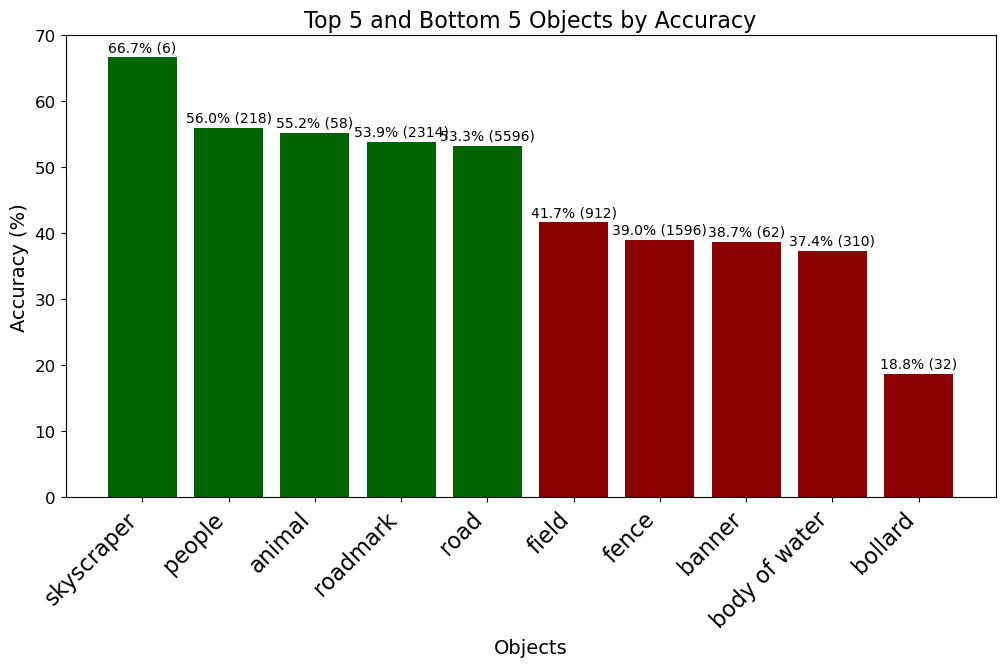

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches  # For creating custom legend handles

# Filter and sort the included objects by accuracy
filtered_objects = top_objects_filtered_included.sort_values(by='accuracy', ascending=False)

# Get the top 5 and bottom 5 objects based on accuracy
top_5_objects = filtered_objects.head(5)
bottom_5_objects = filtered_objects.tail(5)

# Combine the data into a single DataFrame for plotting
combined_objects = pd.concat([top_5_objects, bottom_5_objects])
colors = ['darkgreen'] * len(top_5_objects) + ['darkred'] * len(bottom_5_objects)

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot vertical bars for combined objects
bars = plt.bar(combined_objects['Analysis Result'], combined_objects['accuracy'], color=colors)

# Add labels to each bar (accuracy and number of occurrences)
for bar, accuracy, total in zip(bars, combined_objects['accuracy'], combined_objects['total_occurrences']):
    plt.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
        f'{accuracy:.1f}% ({total})', ha='center', va='bottom', fontsize=10
    )

# Customize the plot
plt.title('Top 5 and Bottom 5 Objects by Accuracy (with occurrences)', fontsize=16)
plt.xlabel('Objects', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)


# Create a custom legend
top_legend = mpatches.Patch(color='darkgreen', label='Top 5')
bottom_legend = mpatches.Patch(color='darkred', label='Bottom 5')
plt.legend(handles=[top_legend, bottom_legend], loc='upper right', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



# Top 3 guesses analysis

In [19]:
import os
import pandas as pd
import numpy as np

# Path to the models folder
models_path = 'models'

# List of probability columns
prob_columns = [
    'prob_Northern America', 'prob_Eastern Asia', 'prob_Southern Europe',
    'prob_Latin America and the Caribbean', 'prob_Sub-Saharan Africa', 
    'prob_Western Asia', 'prob_Northern Europe', 'prob_Western Europe', 
    'prob_South-eastern Asia', 'prob_Eastern Europe', 'prob_Southern Asia', 'prob_nan'
]

# List of sub-regions
sub_regions = [
    'Northern America',
    'Eastern Asia',
    'Southern Europe',
    'Latin America and the Caribbean',
    'Sub-Saharan Africa',
    'Western Asia',
    'Northern Europe',
    'Western Europe',
    'South-eastern Asia',
    'Eastern Europe',
    'Southern Asia',
    'nan'
]

# Function to get the top N indices
def get_top_n_indices(values, n):
    arr = np.array(values)  # Convert list to numpy array for easier manipulation
    top_n_indices = arr.argsort()[-n:][::-1]  # Get indices of the n largest values in descending order
    return top_n_indices.tolist()  # Convert to list

# Function to map indices to sub-region names
def map_indices_to_sub_regions(indices):
    return [sub_regions[i] for i in indices]

# Number of top values to extract
n = 3

# Prepare a dictionary to store results
metrics = []

# Iterate through each subfolder in the models directory
for model_name in os.listdir(models_path):
    model_path = os.path.join(models_path, model_name)
    test_predictions_path = os.path.join(model_path, 'test_predictions.csv')
    
    # Check if test_predictions.csv exists in the folder
    if os.path.exists(test_predictions_path):
        try:
            # Read the test_predictions.csv file
            df2 = pd.read_csv(test_predictions_path)

            # Check if required columns exist
            missing_columns = [col for col in prob_columns if col not in df2.columns]
            if missing_columns:
                print(f"Skipping {model_name} due to missing columns: {missing_columns}")
                continue

            # Create the new DataFrame
            df_result = pd.DataFrame({
                'image_name': df2['image_name'],
                'sub_region': df2['sub-region'],
                'value_list': df2[prob_columns].values.tolist()
            })

            # Apply the function to calculate top N indices
            df_result['top_n_indices'] = df_result['value_list'].apply(lambda x: get_top_n_indices(x, n))

            # Map indices to sub-region names
            df_result['top_n_regions'] = df_result['top_n_indices'].apply(map_indices_to_sub_regions)

            # Check if the correct region is in the top N
            df_result['is_correct'] = df_result.apply(lambda row: row['sub_region'] in row['top_n_regions'], axis=1)

            # Calculate the metric: true / total
            true_count = df_result['is_correct'].sum()
            total_count = len(df_result)
            metric = true_count / total_count

            # Store the result
            metrics.append({'model': model_name, 'metric': metric})
        except Exception as e:
            print(f"Error processing {model_name}: {e}")
            continue

# Convert results to a DataFrame and display
metrics_df = pd.DataFrame(metrics).sort_values('metric', ascending=False)

metrics_df

,model,metric
6,ResNet50,0.729966
7,ResNet50_Augmented,0.709883
0,ResNet101,0.701531
8,ResNet50_Augmented_Unfrozen,0.671505
3,ResNet18,0.663154
1,ResNet101_Augmented,0.661364
2,ResNet101_Augmented_Unfrozen,0.649831
5,ResNet18_Augmented_Unfrozen,0.635713
4,ResNet18_Augmented,0.629747


In [20]:
df_preds = pd.read_csv('models/ResNet50/test_predictions.csv')
prob_columns = [
    'prob_Northern America', 'prob_Eastern Asia', 'prob_Southern Europe',
    'prob_Latin America and the Caribbean', 'prob_Sub-Saharan Africa', 
    'prob_Western Asia', 'prob_Northern Europe', 'prob_Western Europe', 
    'prob_South-eastern Asia', 'prob_Eastern Europe', 'prob_Southern Asia', 'prob_nan'
]

# Example sub-region list
sub_regions = [
    'Northern America',
    'Eastern Asia',
    'Southern Europe',
    'Latin America and the Caribbean',
    'Sub-Saharan Africa',
    'Western Asia',
    'Northern Europe',
    'Western Europe',
    'South-eastern Asia',
    'Eastern Europe',
    'Southern Asia',
    'nan'
]

# Function to get the top N indices
def get_top_n_indices(values, n=3):
    arr = np.array(values)  # Convert list to numpy array
    top_n_indices = arr.argsort()[-n:][::-1]  # Indices of the n largest values in descending order
    return top_n_indices.tolist()  # Convert to list

# Function to map indices to sub-region names
def map_indices_to_sub_regions(indices):
    return [sub_regions[i] for i in indices]

# Process the DataFrame to determine if the correct prediction is in the top 3 guesses
n = 3  # Top N guesses
df_preds['value_list'] = df_preds[prob_columns].values.tolist()  # Combine probabilities into a list
df_preds['top_n_indices'] = df_preds['value_list'].apply(lambda x: get_top_n_indices(x, n))  # Top N indices
df_preds['top_n_regions'] = df_preds['top_n_indices'].apply(map_indices_to_sub_regions)  # Map indices to sub-regions
df_preds['is_correct_top_3'] = df_preds.apply(lambda row: row['sub-region'] in row['top_n_regions'], axis=1)  # Check if correct

# Display the resulting DataFrame with the new column
df_preds_result = df_preds[['image_name', 'sub-region', 'is_correct_top_3']]
df_preds_result


,image_name,sub-region,is_correct_top_3
0,14015.png,South-eastern Asia,False
1,25144.png,South-eastern Asia,False
2,5520.png,Australia and New Zealand,False
3,23265.png,Southern Asia,False
4,15098.png,Northern America,True
...,...,...,...
5024,7536.png,Latin America and the Caribbean,True
5025,9829.png,Australia and New Zealand,False
5026,4356.png,Northern Europe,True
5027,8956.png,Latin America and the Caribbean,True
